# Foundations of Data Mining: Assignment 2

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

In [1]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
InteractiveShell.ast_node_interactivity = "none" 

In [4]:
# We load in our key by placing it in ~/.openml/config

## Kernel selection (4 points (1+2+1))
SVMs can be trained with different kernels. Generate a 2-dimensional dataset as shown below and study the effect of the choice of kernel by visualizing the results.

- Train a SVM classifier on the dataset using respectively a linear, polynomial and radial basis function (RBF) kernel, evaluate the performance of each kernel using 10-fold cross-validation and AUC. Which one works best? Visualize the results. Can you intuitively explain why one kernel is more suited than another?
    - Hint: you can use the visualization code used in class. It is under mglearn/plot_svm.py > plot_svm_kernels().
- Take the RBF kernel and vary both the C parameter and the kernel width ($\gamma$). Use 3 values for each (a very small, default, and very large value). For each of the 9 combinations, create the same RBF plot as before, report the number of support vectors, and the AUC performance. Explain the performance results. When are you over/underfitting?
    - Hint: values for C and $\gamma$ are typically in [$2^{-15}..2^{15}$] on a log scale. 
    - Hint: don't count the support vectors manually, retrieve them from the trained SVM.
- Vary C and $\gamma$ again, but this time use a grid of at least 20x20, vary both parameters uniformly on a log scale, and visualise the results using a $C \times \gamma \rightarrow AUC$ heatmap. Explain the performance results, and compare them to the 9 results obtained in the previous subquestion. Can you also tell in which regions of the heatmap you are over/underfitting?
    - Hint: We've constructed such a heatmap in class and in assignment 1.

In [ ]:
X, y = make_blobs(centers=2, n_samples=1000, random_state=0)

## Robots and SVMs (4 points (2+1+1))

The [Wall Robot Navigation dataset](http://www.openml.org/d/1497) contains about 5500 readings of an ultrasound sensor array mounted on a robot, and your task is to finetune and train an SVM classifier to predict how the robot should move next.

- Make a stratified 80-20 split of the data. On the training set alone, optimize the main hyperparameters of the SVM for Accuracy with a random search. Vary at least the main kernel types (linear, polynomial, and RBF), the C parameter, the $\gamma$ parameter for the RBF kernel and the exponent/degree for the polynomial kernel. Report the optimal hyperparameter settings and Accuracy performance. 
    - The degree of the polynonial is typically in the range 2..10.
    - Hint: note that the hyperparameter ranges depend on each other. For instance, $\gamma$ only makes sense if you have selected the RBF kernel as well. We've seen in class how to define multiple hyperparameter spaces in a random/grid search.
- Use a 5x3-fold (5 outer, 3 inner) nested cross-validation (CV) on the training set to obtain a clean evaluation. Evaluate your optimized hyperparameter settings on the separate test set and discuss the result. Is the performance on the independent test set comparable with the result of the random search?
    - Hint: for the nested resampling, use at least a 10-fold CV for the outer loop. The inner loop can be a 3-fold CV or a simple holdout.
- Train an SVM using the optimal hyperparameter configuration you found and test it on the held out (20%) test set. Compare this Accuracy result with the (mean) result of the nested CV. If you would build this robot in practice, how would you find the hyperparameters to use, and which performance would you expect? Is it truly necessary to tune the hyperparameters? Which hyperparameters were most important to tune?

In [4]:
robot_data = oml.datasets.get_dataset(1497) # Download Robot data
# Get the predictors X and the labels y
X, y = robot_data.get_data(target=robot_data.default_target_attribute); 

## A benchmark study (3 points (2+1))

A benchmark study is an experiment in which multiple algorithms are evaluated on multiple datasets. The end goal is to study whether one algorithm is generally better than the others. Meaningful benchmark studies can grow quite complex, here we do a simplified variant.

* Download OpenML datasets 37, 470, 1120, 1464 and 1471. They are sufficiently large (e.g., at least 500 data points) so that the performance estimation is trustworthy. Select at least three classifiers that we discussed in class, e.g. kNN, Logistic Regression, Random Forests, Gradient Boosting, SVMs, Naive Bayes. Note that some of these algorithms take longer to train. Evaluate all classifiers (with default parameter settings) on all datasets, using a 10-fold CV and AUC. Show the results in a table and interpret them. Which is the best algorithm in this benchmark?
    * Note that these datasets have categorical features, different scales, missing values, and (likely) irrelevant features. You'll need to build pipelines to correctly build all models. Also remove any row identifiers (see, e.g., https://www.openml.org/d/1120)
    * Hint: You can either compare the performances directly, or (better) use a statistical significance test, e.g. a pairwise t-test or (better) Wilcoxon signed ranks test, to see whether the performance differences are significant. This is covered in statistics courses. You can then count wins, ties and losses.
* Repeat the benchmark, but now additionally optimize the main hyperparameters of each algorithm in a grid or random search (explore at least 5 values per hyperparameter, where possible). Does this affect the ranking of the algorithms?

In [7]:
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define datasets and base classifiers
datasets = [37, 470, 1120, 1464, 1471]
classifiers = [neighbors.KNeighborsClassifier(), LogisticRegression(), RandomForestClassifier()]

param_grid = [
    {'classifier': [neighbors.KNeighborsClassifier()], 'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier()], 'preprocessing': [None], 
     'classifier__n_estimators': [20, 50, 80, 120],
     'classifier__max_features': [1, 2, 3]},
    {'classifier': [LogisticRegression()], 'preprocessing': [None], 
     'classifier__n_estimators': [20, 50, 80, 120],
     'classifier__max_features': [1, 2, 3]}
]


kf = KFold(n_splits=10)

# Create imputer to pre-process data
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)

# Create scaler for the classifiers which need this
scaler = StandardScaler()

# Define parameter grids for the classifiers
param_grids = [
    {'estimator__n_neighbors': [1, 3, 5, 7, 9, 11, 33]}, 
    {'estimator__C': [0.001, 0.01, 1, 10, 100, 1000] },
    {'estimator__max_features': list(range(1,5)), 'estimator__n_estimators': [1, 2, 4, 8, 16, 32, 64]}
]

# Score dicts
dsScores = {}
dsGridScores = {}

# Process each dataset
for dindex in datasets:
    # Load data
    data_set = oml.datasets.get_dataset(dindex)
    X, y = data_set.get_data(target=data_set.default_target_attribute)

    scores = {}
    gridScores = {}
    # Run each clf using the corresponding parameter grid
    for clf, grid in zip(classifiers, param_grids):
        # Run 10-fold pipeline
        pipe = Pipeline([("imputer",imp), ("scaler", scaler), ("estimator", clf)])
        score = cross_val_score(pipe, X, y, n_jobs=-1, cv=kf, scoring="roc_auc").mean()
        scores[clf.__class__.__name__] = score;

        # Run gridsearch pipeline
        gs = GridSearchCV(pipe, grid, cv=kf, n_jobs=-1)
        gs.fit(X, y)
        results = pd.DataFrame(gs.cv_results_)
#         print("Best parameters:", gs.best_params_)
#         print("Best cross-validation score (AUC): {:.3f}".format(gs.best_score_))
        gridScores[clf.__class__.__name__] = gs.best_score_

    dsScores[dindex] = scores
    dsGridScores[dindex] = gridScores

# Print default classifier scores
print("Default scores:")
print(pd.DataFrame.from_dict(dsScores))

# Print best grid scores
print("\nOptimized grid scores:")
print(pd.DataFrame.from_dict(dsGridScores))

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    165         sys.exit(msg)
    166     main_globals = sys.modules["__main__"].__dict__
    167     if alter_argv:
    168         sys.argv[0] = mod_spec.origin
    169     return _run_code(code, main_globals, None,
--> 170                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py')
    171 
    172 def run_module(mod_name, init_globals=None,
    173                run_name=None, alter_sys=False):
    174     """Execute a module's code without importing it

...........................................................................
/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x10a73dc90, file "/usr...3.5/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/python3.5/site-packages/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x10a73dc90, file "/usr...3.5/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/python3.5/site-packages/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/usr/local/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    469             return self.subapp.start()
    470         if self.poller is not None:
    471             self.poller.start()
    472         self.kernel.start()
    473         try:
--> 474             ioloop.IOLoop.instance().start()
    475         except KeyboardInterrupt:
    476             pass
    477 
    478 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/usr/local/lib/python3.5/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
/usr/local/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/usr/local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/usr/local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/usr/local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/usr/local/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/usr/local/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/usr/local/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn import neighbors\nfrom sklearn.linea...es:")\nprint(pd.DataFrame.from_dict(dsGridScores))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-03-07T12:27:18.969671', 'msg_id': '3AEC3AC76CCE478F82F26CA7B4950E6B', 'msg_type': 'execute_request', 'session': '4300ED3739A7407B9133B0FD170679B7', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '3AEC3AC76CCE478F82F26CA7B4950E6B', 'msg_type': 'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'4300ED3739A7407B9133B0FD170679B7']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn import neighbors\nfrom sklearn.linea...es:")\nprint(pd.DataFrame.from_dict(dsGridScores))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-03-07T12:27:18.969671', 'msg_id': '3AEC3AC76CCE478F82F26CA7B4950E6B', 'msg_type': 'execute_request', 'session': '4300ED3739A7407B9133B0FD170679B7', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '3AEC3AC76CCE478F82F26CA7B4950E6B', 'msg_type': 'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/usr/local/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'4300ED3739A7407B9133B0FD170679B7'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn import neighbors\nfrom sklearn.linea...es:")\nprint(pd.DataFrame.from_dict(dsGridScores))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-03-07T12:27:18.969671', 'msg_id': '3AEC3AC76CCE478F82F26CA7B4950E6B', 'msg_type': 'execute_request', 'session': '4300ED3739A7407B9133B0FD170679B7', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '3AEC3AC76CCE478F82F26CA7B4950E6B', 'msg_type': 'execute_request', 'parent_header': {}})
    385         if not silent:
    386             self.execution_count += 1
    387             self._publish_execute_input(code, parent, self.execution_count)
    388 
    389         reply_content = self.do_execute(code, silent, store_history,
--> 390                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    391 
    392         # Flush output before sending the reply.
    393         sys.stdout.flush()
    394         sys.stderr.flush()

...........................................................................
/usr/local/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='from sklearn import neighbors\nfrom sklearn.linea...es:")\nprint(pd.DataFrame.from_dict(dsGridScores))', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'from sklearn import neighbors\nfrom sklearn.linea...es:")\nprint(pd.DataFrame.from_dict(dsGridScores))'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/usr/local/lib/python3.5/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('from sklearn import neighbors\nfrom sklearn.linea...es:")\nprint(pd.DataFrame.from_dict(dsGridScores))',), **kwargs={'silent': False, 'store_history': True})
    496             )
    497         self.payload_manager.write_payload(payload)
    498 
    499     def run_cell(self, *args, **kwargs):
    500         self._last_traceback = None
--> 501         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('from sklearn import neighbors\nfrom sklearn.linea...es:")\nprint(pd.DataFrame.from_dict(dsGridScores))',)
        kwargs = {'silent': False, 'store_history': True}
    502 
    503     def _showtraceback(self, etype, evalue, stb):
    504         # try to preserve ordering of tracebacks and print statements
    505         sys.stdout.flush()

...........................................................................
/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from sklearn import neighbors\nfrom sklearn.linea...es:")\nprint(pd.DataFrame.from_dict(dsGridScores))', store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'none'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.For object>, <_ast.Expr object>, <_ast.Expr object>, ...], cell_name='<ipython-input-7-567735b0437f>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1115196d8, execution_..._before_exec=None error_in_exec=None result=None>)
   2816 
   2817         try:
   2818             for i, node in enumerate(to_run_exec):
   2819                 mod = ast.Module([node])
   2820                 code = compiler(mod, cell_name, "exec")
-> 2821                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x1114bdb70, file "<ipython-input-7-567735b0437f>", line 48>
        result = <ExecutionResult object at 1115196d8, execution_..._before_exec=None error_in_exec=None result=None>
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])

...........................................................................
/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x1114bdb70, file "<ipython-input-7-567735b0437f>", line 48>, result=<ExecutionResult object at 1115196d8, execution_..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x1114bdb70, file "<ipython-input-7-567735b0437f>", line 48>
        self.user_global_ns = {'ConfigManager': <class 'notebook.services.config.manager.ConfigManager'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'HTML': <class 'IPython.core.display.HTML'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, 'In': ['', "from sklearn import neighbors\nfrom sklearn.linea...ridScores))\n\nif __name__ == '__main__':\n    run()", 'get_ipython().magic(\'matplotlib inline\')\nfrom pr...InteractiveShell.ast_node_interactivity = "none" ', '# We load in our key by placing it in ~/.openml/config', '# We load in our key by placing it in ~/.openml/config', 'from sklearn import neighbors\nfrom sklearn.linea...es:")\nprint(pd.DataFrame.from_dict(dsGridScores))', 'from sklearn import neighbors\nfrom sklearn.linea...es:")\nprint(pd.DataFrame.from_dict(dsGridScores))', 'from sklearn import neighbors\nfrom sklearn.linea...es:")\nprint(pd.DataFrame.from_dict(dsGridScores))'], 'InteractiveShell': <class 'IPython.core.interactiveshell.InteractiveShell'>, 'KFold': <class 'sklearn.model_selection._split.KFold'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, ...}
        self.user_ns = {'ConfigManager': <class 'notebook.services.config.manager.ConfigManager'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'HTML': <class 'IPython.core.display.HTML'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, 'In': ['', "from sklearn import neighbors\nfrom sklearn.linea...ridScores))\n\nif __name__ == '__main__':\n    run()", 'get_ipython().magic(\'matplotlib inline\')\nfrom pr...InteractiveShell.ast_node_interactivity = "none" ', '# We load in our key by placing it in ~/.openml/config', '# We load in our key by placing it in ~/.openml/config', 'from sklearn import neighbors\nfrom sklearn.linea...es:")\nprint(pd.DataFrame.from_dict(dsGridScores))', 'from sklearn import neighbors\nfrom sklearn.linea...es:")\nprint(pd.DataFrame.from_dict(dsGridScores))', 'from sklearn import neighbors\nfrom sklearn.linea...es:")\nprint(pd.DataFrame.from_dict(dsGridScores))'], 'InteractiveShell': <class 'IPython.core.interactiveshell.InteractiveShell'>, 'KFold': <class 'sklearn.model_selection._split.KFold'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/Users/ruudandriessen/study/2imw30/2-Assignment/<ipython-input-7-567735b0437f> in <module>()
     54     gridScores = {}
     55     # Run each clf using the corresponding parameter grid
     56     for clf, grid in zip(classifiers, param_grids):
     57         # Run 10-fold pipeline
     58         pipe = Pipeline([("imputer",imp), ("scaler", scaler), ("estimator", clf)])
---> 59         score = cross_val_score(pipe, X, y, n_jobs=-1, cv=kf, scoring="roc_auc").mean()
     60         scores[clf.__class__.__name__] = score;
     61 
     62         # Run gridsearch pipeline
     63         gs = GridSearchCV(pipe, grid, cv=kf, n_jobs=-1)

...........................................................................
/usr/local/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in cross_val_score(estimator=Pipeline(steps=[('imputer', Imputer(axis=0, copy...eighbors=5, p=2,
           weights='uniform'))]), X=array([[  28.797,   16.002,    2.645, ...,   -8.....,   31.476,   52.731,  272.317]], dtype=float32), y=array([0, 0, 0, ..., 1, 1, 1]), groups=None, scoring='roc_auc', cv=KFold(n_splits=10, random_state=None, shuffle=False), n_jobs=-1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')
    135     parallel = Parallel(n_jobs=n_jobs, verbose=verbose,
    136                         pre_dispatch=pre_dispatch)
    137     scores = parallel(delayed(_fit_and_score)(clone(estimator), X, y, scorer,
    138                                               train, test, verbose, None,
    139                                               fit_params)
--> 140                       for train, test in cv_iter)
        cv_iter = [(array([ 1902,  1903,  1904, ..., 19017, 19018, 19019]), array([   0,    1,    2, ..., 1899, 1900, 1901])), (array([    0,     1,     2, ..., 19017, 19018, 19019]), array([1902, 1903, 1904, ..., 3801, 3802, 3803])), (array([    0,     1,     2, ..., 19017, 19018, 19019]), array([3804, 3805, 3806, ..., 5703, 5704, 5705])), (array([    0,     1,     2, ..., 19017, 19018, 19019]), array([5706, 5707, 5708, ..., 7605, 7606, 7607])), (array([    0,     1,     2, ..., 19017, 19018, 19019]), array([7608, 7609, 7610, ..., 9507, 9508, 9509])), (array([    0,     1,     2, ..., 19017, 19018, 19019]), array([ 9510,  9511,  9512, ..., 11409, 11410, 11411])), (array([    0,     1,     2, ..., 19017, 19018, 19019]), array([11412, 11413, 11414, ..., 13311, 13312, 13313])), (array([    0,     1,     2, ..., 19017, 19018, 19019]), array([13314, 13315, 13316, ..., 15213, 15214, 15215])), (array([    0,     1,     2, ..., 19017, 19018, 19019]), array([15216, 15217, 15218, ..., 17115, 17116, 17117])), (array([    0,     1,     2, ..., 17115, 17116, 17117]), array([17118, 17119, 17120, ..., 19017, 19018, 19019]))]
    141     return np.array(scores)[:, 0]
    142 
    143 
    144 def _fit_and_score(estimator, X, y, scorer, train, test, verbose,

...........................................................................
/usr/local/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object cross_val_score.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Tue Mar  7 12:27:29 2017
PID: 39639               Python 3.5.1: /usr/local/opt/python3/bin/python3.5
...........................................................................
/usr/local/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(steps=[('imputer', Imputer(axis=0, copy...eighbors=5, p=2,
           weights='uniform'))]), array([[  28.797,   16.002,    2.645, ...,   -8.....,   31.476,   52.731,  272.317]], dtype=float32), array([0, 0, 0, ..., 1, 1, 1]), make_scorer(roc_auc_score, needs_threshold=True), array([ 1902,  1903,  1904, ..., 19017, 19018, 19019]), array([   0,    1,    2, ..., 1899, 1900, 1901]), 0, None, None), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(steps=[('imputer', Imputer(axis=0, copy...eighbors=5, p=2,
           weights='uniform'))]), array([[  28.797,   16.002,    2.645, ...,   -8.....,   31.476,   52.731,  272.317]], dtype=float32), array([0, 0, 0, ..., 1, 1, 1]), make_scorer(roc_auc_score, needs_threshold=True), array([ 1902,  1903,  1904, ..., 19017, 19018, 19019]), array([   0,    1,    2, ..., 1899, 1900, 1901]), 0, None, None)
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(steps=[('imputer', Imputer(axis=0, copy...eighbors=5, p=2,
           weights='uniform'))]), X=array([[  28.797,   16.002,    2.645, ...,   -8.....,   31.476,   52.731,  272.317]], dtype=float32), y=array([0, 0, 0, ..., 1, 1, 1]), scorer=make_scorer(roc_auc_score, needs_threshold=True), train=array([ 1902,  1903,  1904, ..., 19017, 19018, 19019]), test=array([   0,    1,    2, ..., 1899, 1900, 1901]), verbose=0, parameters=None, fit_params={}, return_train_score=False, return_parameters=False, return_n_test_samples=False, return_times=False, error_score='raise')
    255                              " numeric value. (Hint: if using 'raise', please"
    256                              " make sure that it has been spelled correctly.)")
    257 
    258     else:
    259         fit_time = time.time() - start_time
--> 260         test_score = _score(estimator, X_test, y_test, scorer)
        test_score = undefined
        estimator = Pipeline(steps=[('imputer', Imputer(axis=0, copy...eighbors=5, p=2,
           weights='uniform'))])
        X_test = array([[  28.797,   16.002,    2.645, ...,   -8.....,   -7.31 ,   66.01 ,  155.056]], dtype=float32)
        y_test = array([0, 0, 0, ..., 0, 0, 0])
        scorer = make_scorer(roc_auc_score, needs_threshold=True)
    261         score_time = time.time() - start_time - fit_time
    262         if return_train_score:
    263             train_score = _score(estimator, X_train, y_train, scorer)
    264 

...........................................................................
/usr/local/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in _score(estimator=Pipeline(steps=[('imputer', Imputer(axis=0, copy...eighbors=5, p=2,
           weights='uniform'))]), X_test=array([[  28.797,   16.002,    2.645, ...,   -8.....,   -7.31 ,   66.01 ,  155.056]], dtype=float32), y_test=array([0, 0, 0, ..., 0, 0, 0]), scorer=make_scorer(roc_auc_score, needs_threshold=True))
    283 def _score(estimator, X_test, y_test, scorer):
    284     """Compute the score of an estimator on a given test set."""
    285     if y_test is None:
    286         score = scorer(estimator, X_test)
    287     else:
--> 288         score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = make_scorer(roc_auc_score, needs_threshold=True)
        estimator = Pipeline(steps=[('imputer', Imputer(axis=0, copy...eighbors=5, p=2,
           weights='uniform'))])
        X_test = array([[  28.797,   16.002,    2.645, ...,   -8.....,   -7.31 ,   66.01 ,  155.056]], dtype=float32)
        y_test = array([0, 0, 0, ..., 0, 0, 0])
    289     if hasattr(score, 'item'):
    290         try:
    291             # e.g. unwrap memmapped scalars
    292             score = score.item()

...........................................................................
/usr/local/lib/python3.5/site-packages/sklearn/metrics/scorer.py in __call__(self=make_scorer(roc_auc_score, needs_threshold=True), clf=Pipeline(steps=[('imputer', Imputer(axis=0, copy...eighbors=5, p=2,
           weights='uniform'))]), X=array([[  28.797,   16.002,    2.645, ...,   -8.....,   -7.31 ,   66.01 ,  155.056]], dtype=float32), y=array([0, 0, 0, ..., 0, 0, 0]), sample_weight=None)
    191         if sample_weight is not None:
    192             return self._sign * self._score_func(y, y_pred,
    193                                                  sample_weight=sample_weight,
    194                                                  **self._kwargs)
    195         else:
--> 196             return self._sign * self._score_func(y, y_pred, **self._kwargs)
        self._sign = 1
        self._score_func = <function roc_auc_score>
        y = array([0, 0, 0, ..., 0, 0, 0])
        y_pred = array([ 0.2,  0.4,  1. , ...,  0. ,  0.2,  0.6])
        self._kwargs = {}
    197 
    198     def _factory_args(self):
    199         return ", needs_threshold=True"
    200 

...........................................................................
/usr/local/lib/python3.5/site-packages/sklearn/metrics/ranking.py in roc_auc_score(y_true=array([0, 0, 0, ..., 0, 0, 0]), y_score=array([ 0.2,  0.4,  1. , ...,  0. ,  0.2,  0.6]), average='macro', sample_weight=None)
    255                                         sample_weight=sample_weight)
    256         return auc(fpr, tpr, reorder=True)
    257 
    258     return _average_binary_score(
    259         _binary_roc_auc_score, y_true, y_score, average,
--> 260         sample_weight=sample_weight)
        sample_weight = None
    261 
    262 
    263 def _binary_clf_curve(y_true, y_score, pos_label=None, sample_weight=None):
    264     """Calculate true and false positives per binary classification threshold.

...........................................................................
/usr/local/lib/python3.5/site-packages/sklearn/metrics/base.py in _average_binary_score(binary_metric=<function roc_auc_score.<locals>._binary_roc_auc_score>, y_true=array([0, 0, 0, ..., 0, 0, 0]), y_score=array([ 0.2,  0.4,  1. , ...,  0. ,  0.2,  0.6]), average='macro', sample_weight=None)
     79     y_type = type_of_target(y_true)
     80     if y_type not in ("binary", "multilabel-indicator"):
     81         raise ValueError("{0} format is not supported".format(y_type))
     82 
     83     if y_type == "binary":
---> 84         return binary_metric(y_true, y_score, sample_weight=sample_weight)
        binary_metric = <function roc_auc_score.<locals>._binary_roc_auc_score>
        y_true = array([0, 0, 0, ..., 0, 0, 0])
        y_score = array([ 0.2,  0.4,  1. , ...,  0. ,  0.2,  0.6])
        sample_weight = None
     85 
     86     check_consistent_length(y_true, y_score, sample_weight)
     87     y_true = check_array(y_true)
     88     y_score = check_array(y_score)

...........................................................................
/usr/local/lib/python3.5/site-packages/sklearn/metrics/ranking.py in _binary_roc_auc_score(y_true=array([0, 0, 0, ..., 0, 0, 0]), y_score=array([ 0.2,  0.4,  1. , ...,  0. ,  0.2,  0.6]), sample_weight=None)
    246     0.75
    247 
    248     """
    249     def _binary_roc_auc_score(y_true, y_score, sample_weight=None):
    250         if len(np.unique(y_true)) != 2:
--> 251             raise ValueError("Only one class present in y_true. ROC AUC score "
    252                              "is not defined in that case.")
    253 
    254         fpr, tpr, tresholds = roc_curve(y_true, y_score,
    255                                         sample_weight=sample_weight)

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.
___________________________________________________________________________

## Gaussian Processes (2 points (1+1))

Consider the RAM prices dataset (included in the data folder). Separate the data in a training set of all data points up until the year 2000, and a test set with all points after that.

- Train several of the algorithms we have covered in the course that can handle regression. Include at least linear regression, decision tree, and RandomForest. Which ones give the best $R^2$ performance on the test set? Plot the predictions (both on the training and test data) on the figure below. Use different colors for different algorithms or build multiple plots.
- Train a Gaussian process on an increasing amount of samples of the training data. Start with 5 random sample and plot the predictions (both the mean and the uncertainty interval) for both training and test data, as shown in class. Now add 5 more points and retrain and redraw. Do this a couple of times and interpret/explain what you see. Finally, train the Gaussian on the full dataset and again show plot the predictions. Evaluate on the test set using  $R^2$. Compare these results with those achieved with other algorithms and explain.

<bound method NDFrame.as_matrix of 0      1957.00
1      1959.00
2      1960.00
3      1965.00
4      1970.00
5      1973.00
6      1974.00
7      1975.00
8      1975.08
9      1975.25
10     1975.75
11     1976.00
12     1976.17
13     1976.42
14     1976.58
15     1977.08
16     1978.17
17     1978.25
18     1978.33
19     1978.50
20     1978.58
21     1978.75
22     1979.00
23     1979.75
24     1980.00
25     1981.00
26     1981.58
27     1982.00
28     1982.17
29     1982.67
        ...   
172    1997.25
173    1997.33
174    1997.42
175    1997.50
176    1997.58
177    1997.67
178    1997.75
179    1997.83
180    1997.92
181    1998.00
182    1998.08
183    1998.17
184    1998.25
185    1998.33
186    1998.42
187    1998.58
188    1998.67
189    1998.75
190    1998.83
191    1998.92
192    1999.08
193    1999.13
194    1999.17
195    1999.25
196    1999.33
197    1999.50
198    1999.67
199    1999.75
200    1999.83
201    1999.92
Name: date, dtype: float64>


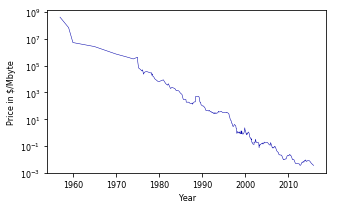

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

ram_prices = pd.read_csv('data/ram_price.csv')

plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte");

train = ram_prices.query("date < 2000")
test = ram_prices.query("date >= 2000")

print (train.date.array)
algorithms = [LinearRegression(), RandomForestRegressor(), DecisionTreeRegressor()]

# for alg in algorithms:
#     alg.fit(train.date, train.price)
#     print(alg.score(test.date, test.price))
#     print(cross_val_score(alg, ram_prices.date, ram_prices.price, cv=10, scoring="r2").mean())
   

## A mini-data mining challenge (2 points (+1))

The goal here is to use everything you have learned to build the best model for a given classification task. The task is hosted on OpenML, so you will receive the train-test splits, and your model will be evaluated on the server. The goal is to reasonably select algorithms and hyperparameter settings to obtain the best model. You can also do model selection and parameter optimization as you have done before. Skeleton code is provided in the OpenML tutorial.

- All details can be found online:
    - The OpenML Task ID is 145677: https://www.openml.org/t/145677
    - The dataset description can be found here: https://www.openml.org/d/4134
- A leaderboard is kept of the best models: https://www.openml.org/t/145677#!people
    - You are able to see the solutions of others (by clicking in the timeline or run list), but resubmission of the exact same solution does not register on the leaderboard.
    - You can share one account (one API key) per team. In case you use two, we take the one that performs best.
- You can document the different experiments that you ran in this notebook. For each experiment, provide a description of how you chose the algorithms and parameters that you submitted. Try to reason about which experiments to try, don't just do an immense random search.
- Points are rewarded as follows:
    - 1 point for the breadth of experiments you ran (algorithms, hyperparameter settings)
    - 1 point for reasoning/insight and interpretation of the results
    - 1 (bonus) point for every team who has uploaded the best solution thus far **on AUC** (who reaches the top of the leaderboard at any moment during the assignment)
        - Note: On the leaderboard page, the 'frontier' line is drawn, and your top ranking is also shown in the table.
        
Note: Report AUC scores in your report as well. In case of issues with OpenML we will use the experiments and scores mentioned your report.

In [7]:
import openml as oml

# Load task data
task = oml.tasks.get_task(145677)
data = oml.datasets.get_dataset(task.dataset_id)
X, y = data.get_data(target=data.default_target_attribute)

We have lots of features (1777) Hence, we should either figure something out to reduce the amount features, or use a classifier which handles a lot of features well. Initially, our thoughts fell on using a random forest classifier without selecting features (this is what the decision trees do themselves anyhow).

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile, SelectFromModel, RFE

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# We don't need a scalar since the dataset is already normalized

# Create classifier
clf = RandomForestClassifier(random_state=1, n_estimators=2048, min_samples_split=4, criterion="entropy", n_jobs=-1)

# Build pipeline
pipe = Pipeline([
    ('classifier', clf)
])

# grid = {
#     "classifier__min_samples_split": [2, 4, 8]
#     "classifier__" : ["entropy","gini"]
# }
# gs = GridSearchCV(pipe, grid, cv=10, n_jobs=-1, scoring="roc_auc", verbose=1)
# gs.fit(X, y)

# print(gs.best_score_)     
# print(gs.best_params_)


task = oml.tasks.get_task(145677)
print("Running..")
run = oml.runs.run_task(task, pipe)
print("Publishing run")
myrun = run.publish()
print("RF on %s: http://www.openml.org/r/%d" % (data.name, myrun.run_id))

Running..
Publishing run
RF on Bioresponse: http://www.openml.org/r/1849099


This result was decent, but we did not find any way to significantly improve this. Hence, we now attempted to use logistic regression. But we still wanted to keep the performance from the RandomForest classifier. Hence we used this as the feature selector before we ran the LogisticRegression.

In [25]:
from sklearn.svm import SVC

# Create feature selector 
fs = SelectFromModel(RandomForestClassifier(random_state=1, criterion="entropy"))

# Create default classifier
clf = SVC()

pipe = Pipeline([
    ('feature_select', fs),
    ('classifier', clf)
])

grid = {
    "classifier__C": [0.01, 0.1, 1, 10, 100],
    "classifier__kernel": ["linear", "poly", "rbf"],
    "classifier__gamma": [0.01, 0.1, 1, 10, 100]
}
gs = GridSearchCV(pipe, grid, cv=10, n_jobs=-1, scoring="roc_auc", verbose=1)
gs.fit(X, y)

print(gs.best_score_)     
print(gs.best_params_)

Fitting 10 folds for each of 75 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 43.9min finished


0.859742509623
{'classifier__gamma': 0.01, 'classifier__C': 10, 'classifier__kernel': 'rbf'}


The results from this classification where significantly higher then we expected.
Therefore we attempted to improve the best results further by increasing the number of estimators of the random forest classifier. And to optimize only the rbf kernel further.

In [34]:
# Create feature selector 
fs = SelectFromModel(RandomForestClassifier(random_state=1, n_estimators=256, criterion="entropy"))

# Create default classifier
clf = SVC(kernel="rbf", C=10, gamma=0.01)

pipe = Pipeline([
    ('feature_select', fs),
    ('classifier', clf)
])

task = oml.tasks.get_task(145677)
print("Running..")
run = oml.runs.run_task(task, pipe)
print("Publishing run")
myrun = run.publish()
print("SVM on %s: http://www.openml.org/r/%d" % (data.name, myrun.run_id))

Running..
Publishing run
RF on Bioresponse: http://www.openml.org/r/1849100
